In [72]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow_addons.optimizers import RectifiedAdam

import sys
sys.path.append('..')
sys.path.append('../Utils')
sys.path.append('../Models')

from network_tools import *
from hnet import *

%pylab inline

# path to the pre-trained model
PRE_TRAINED_MODEL_PATH = '../SavedModels/ecg_supervised_224.h5'

Populating the interactive namespace from numpy and matplotlib


# HemoNet: Model loading demonstration
The notebook shows the simple procedure by which one can load, train, and do inference with HemoNet.

The lead order is: ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

## Example ECG

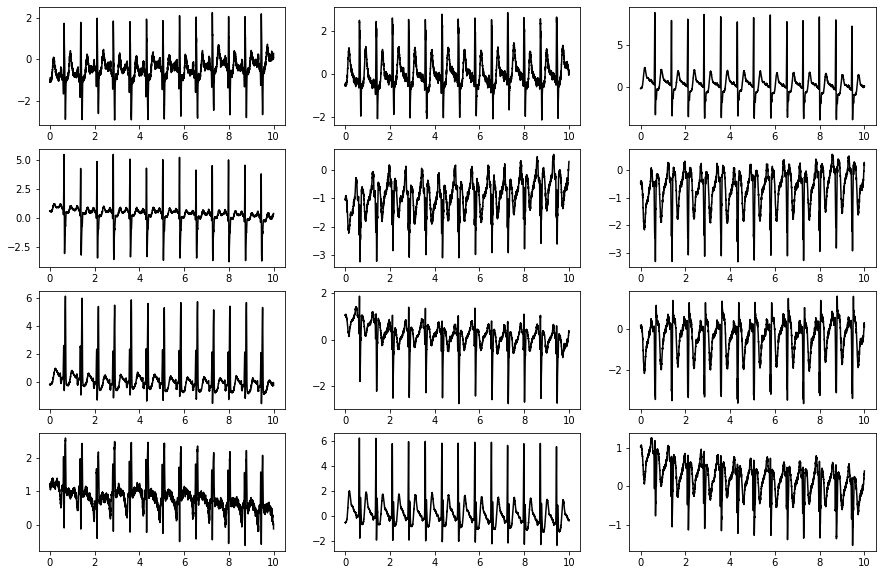

In [73]:
# load the file
ecg_ex = pd.read_csv('samples.csv')

# a bit of processing
ecg_array = np.array(ecg_ex[ecg_ex.columns[1:13]].iloc[1:,:].astype(float))

# downsample to 500 Hz, to get the right shape
ecg_array = ecg_array[::2,:]
time = np.linspace(0,10,5000)

# an input ECG is normalized by the mean and variance of all the samples in that ECG
ecg_array -= np.mean(ecg_array)
ecg_array /= np.std(ecg_array)

# plot the normalized ECGs
figs, axs = plt.subplots(4,3,figsize=[15,10])
for i in range(12) :
    axs[i%4,i%3].plot(time,ecg_array[:,i], 'k')

## Instantiate and training HemoNet
e.g. if you would like to start with our pre-trained model, then tune with your own data

In [74]:
# load the pre-trained model
pre_trained_model = load_model(PRE_TRAINED_MODEL_PATH, custom_objects={
            'swish': tf.nn.swish,
            'RectifiedAdam': RectifiedAdam,
            'pearson': pearson,
        })

# take the model up to the latent layer, 224 nodes
latent = tf.keras.Model(pre_trained_model.inputs, pre_trained_model.get_layer('embed').output)

# append the additional layers to the pre-trained layers which project to the latent space
full_model = AppendNet(latent)
full_model.build((None,5000,12))

In [75]:
########## DATA ###########
'''
For the purposes of this demonstration, we generate random inputs and labels.
The actual, pressure-matched training data will be de-identified released when
possible.
'''

N = 100

X_train = np.random.rand(N,5000,12)
y_train = np.random.rand(N,4) > 0.5

In [76]:
##### TRAIN THE MODEL #####
#   as much as you want   #
#     or not at all       #

optimizer = tf.keras.optimizers.Adam() # can modify LR, of course
loss_fn = tf.keras.losses.BinaryCrossentropy()
epochs = 1

'''
Note: We wrote our own training loop so we could freely modify the procedure.
Feel free to do so (https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch)
'''
full_model.compile(optimizer, loss_fn)
full_model.fit(X_train, y_train, epochs=epochs)

4/4 [==============================] - 3s 333ms/step - loss: 0.7508


In [77]:
# Now, we can do inference at will

X_test = np.random.rand(100,5000,12)
y_pred = full_model.predict(X_test)

## Load the trained HemoNet
Here, we load the model that we had trained and used in our paper. All ten bootstraps are available.

Due to an issue with tensorflow related to loading operations with custom gradents, we use our own function to load the weights.

In [78]:
# first, instantiate the model

pre_trained_model = load_model(PRE_TRAINED_MODEL_PATH, custom_objects={
            'swish': tf.nn.swish,
            'RectifiedAdam': RectifiedAdam,
            'pearson': pearson,
        })

# take the model up to the latent layer, 224 nodes
latent = tf.keras.Model(pre_trained_model.inputs, pre_trained_model.get_layer('embed').output)

# append the additional layers to the pre-trained layers which project to the latent space
trained_model = AppendNet(latent)

# load the weights
trained_model = load_weights(trained_model,'../SavedModels/FinalBstraps/bs0/weights.pkl')

In [79]:
# we get an output with shape 1x4 for our example ECG, as desired
sample_out = trained_model.predict(ecg_array[np.newaxis,...])[0]
print(sample_out)

[0.5484606  0.4466602  0.32655683 0.61969393]


## Unreliability

We can now compute the unreliablity score,

<center>$U = |p_{pred}(mPAP > 20 \mbox{ mmHg}) - p(PH)|$</center>

where 

<center>$p(PH) = p_{pred}(PCWP > 15 \mbox{ mmHg}) + p_{pred}(PVR > 3 \mbox{ Wood's Units}) - p_{pred}(PCWP > 15 \mbox{ mmHg})\cdot p_{pred}(PVR > 3 \mbox{ Wood's Units})$</center>



In [80]:
p_PH = sample_out[1] + sample_out[2] - sample_out[1] * sample_out[2]

U = np.abs(sample_out[0] - p_PH)

print("The unreliablity score is %.3f" % U)

The unreliablity score is 0.079


The unreliability score is low, so we know that the model prediction is probably not unreliable.